In [24]:
# Imports 
import pandas as pd
from sklearn.impute import KNNImputer
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Importing data 

In [2]:
df = pd.read_csv('stationary_data.csv')

# Imputer 

In [5]:
imputer = KNNImputer(n_neighbors=2)
df['reddit_sentiment'],df['reddit_post_count'],df['twitter_sentiment'] = imputer.fit_transform(df[['reddit_sentiment','reddit_post_count','twitter_sentiment']]).T

# Train Test Val Split

In [7]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

# Standardize

In [8]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/tmp/ipykernel_32412/1429736173.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_mean = train_df.mean()
/tmp/ipykernel_32412/1429736173.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_std = train_df.std()


# Modelling

In [9]:
sequence_length = 7
train_df['target'] = train_df['close_price'].shift(-sequence_length)
train_df.drop('start', axis = 1, inplace = True)

In [12]:
train_df.dropna()

,close_price,macd,reddit_post_count,reddit_sentiment,rsi,tweet_count,twitter_sentiment,volatility,volume,target
0,-1.282915,0.659219,-1.244836,0.563656,0.145075,0.409370,0.708600,-0.820883,0.005212,1.056800
1,0.187977,1.176309,-0.190403,-2.187755,0.266023,-0.388832,-0.074973,-0.113681,1.203402,-2.237758
2,1.400588,4.069058,0.597392,0.903096,1.021837,-0.493172,0.543006,1.435256,0.503616,2.510337
3,-1.731595,3.262921,-2.226549,-0.168516,0.043896,-1.449731,1.024172,0.966801,-1.356202,-0.248610
4,-1.105872,0.591200,0.657991,0.489839,-0.814077,0.542666,1.859351,0.049367,-0.601460,-1.127149
...,...,...,...,...,...,...,...,...,...,...
893,0.058953,0.013762,-0.578240,-0.571180,-0.005860,0.982887,-1.434736,-0.163125,0.137616,-0.110625
894,-0.087907,-0.071556,0.645871,-1.534328,-0.360344,7.794126,-2.789252,0.042164,-0.550381,-0.164714
895,-0.017652,-0.155452,-1.305435,0.530168,-0.445726,-0.612211,-2.407624,-0.030022,-0.033059,-0.170655
896,0.144526,-0.080090,0.209554,1.456391,0.175874,-6.587683,-1.985591,-0.329861,-0.434900,0.317315


In [14]:
X_train = train_df.drop('target', axis = 1)
y_train = train_df['target']
dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_train, y_train, sequence_length=10, batch_size = 16)


In [15]:
exx, exxy = next(iter(dataset))
train_df.iloc[:10]
test_df['target'] = test_df['close_price'].shift(-sequence_length)


In [18]:
test_df.drop('start', axis = 1, inplace = True)

In [19]:
X_test = test_df.drop('target', axis = 1)
y_test = test_df['target']



In [20]:
dataset_test = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_test, y_test, sequence_length=10)


In [21]:
etx, ety = next(iter(dataset_test))
val_df['target'] = val_df['close_price'].shift(-sequence_length)
val_df.drop('start', axis = 1, inplace = True)
X_val = val_df.drop('target', axis = 1)
y_val =val_df['target']
dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_val, y_val, sequence_length=10)
evx, evy = next(iter(dataset_val))

# Train model

In [39]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(64),
    #tf.keras.layers.Dropout(0.2),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.Dense(units=16),
    tf.keras.layers.Dense(units=1)
    # Adding a second LSTM layer and some Dropout regularisation
])

# regularization?
# GRU layer

In [40]:
lstm_model.compile(optimizer = 'Adam', loss = 'mae')

In [41]:
es = EarlyStopping(patience = 20, restore_best_weights=True)

In [42]:
reduce_lr = ReduceLROnPlateau(patience = 15)

In [43]:
lstm_model.fit(dataset, validation_data = dataset_val, epochs = 2_000, callbacks = [es, reduce_lr])

Epoch 1/2000
56/56 [==============================] - 5s 36ms/step - loss: 0.6726 - val_loss: 0.6503
Epoch 2/2000
56/56 [==============================] - 1s 27ms/step - loss: 0.6532 - val_loss: 0.6290
Epoch 3/2000
56/56 [==============================] - 1s 25ms/step - loss: 0.6408 - val_loss: 0.6204
Epoch 4/2000
56/56 [==============================] - 1s 25ms/step - loss: 0.5911 - val_loss: 0.5846
Epoch 5/2000
56/56 [==============================] - 1s 24ms/step - loss: 0.3261 - val_loss: 0.3929
Epoch 6/2000
56/56 [==============================] - 1s 26ms/step - loss: 0.1696 - val_loss: 0.2594
Epoch 7/2000
56/56 [==============================] - 1s 26ms/step - loss: 0.1439 - val_loss: 0.2486
Epoch 8/2000
56/56 [==============================] - 1s 23ms/step - loss: 0.1109 - val_loss: 0.2222
Epoch 9/2000
56/56 [==============================] - 1s 23ms/step - loss: 0.0964 - val_loss: 0.2233
Epoch 10/2000
56/56 [==============================] - 1s 23ms/step - loss: 0.0993 - val_lo

56/56 [==============================] - 2s 37ms/step - loss: 0.0152 - val_loss: 0.1052
Epoch 82/2000
56/56 [==============================] - 2s 41ms/step - loss: 0.0146 - val_loss: 0.1030
Epoch 83/2000
56/56 [==============================] - 2s 40ms/step - loss: 0.0138 - val_loss: 0.1029
Epoch 84/2000
56/56 [==============================] - 2s 41ms/step - loss: 0.0130 - val_loss: 0.1016
Epoch 85/2000
56/56 [==============================] - 2s 40ms/step - loss: 0.0123 - val_loss: 0.1013
Epoch 86/2000
56/56 [==============================] - 2s 40ms/step - loss: 0.0123 - val_loss: 0.1014
Epoch 87/2000
56/56 [==============================] - 2s 39ms/step - loss: 0.0129 - val_loss: 0.0987
Epoch 88/2000
56/56 [==============================] - 2s 35ms/step - loss: 0.0117 - val_loss: 0.0983
Epoch 89/2000
56/56 [==============================] - 2s 35ms/step - loss: 0.0121 - val_loss: 0.0984
Epoch 90/2000
56/56 [==============================] - 2s 40ms/step - loss: 0.0114 - val_loss: 0

Epoch 161/2000
56/56 [==============================] - 2s 35ms/step - loss: 0.0072 - val_loss: 0.0750
Epoch 162/2000
56/56 [==============================] - 2s 36ms/step - loss: 0.0071 - val_loss: 0.0750
Epoch 163/2000
56/56 [==============================] - 2s 37ms/step - loss: 0.0076 - val_loss: 0.0747
Epoch 164/2000
56/56 [==============================] - 2s 36ms/step - loss: 0.0073 - val_loss: 0.0743
Epoch 165/2000
56/56 [==============================] - 2s 32ms/step - loss: 0.0068 - val_loss: 0.0720
Epoch 166/2000
56/56 [==============================] - 2s 38ms/step - loss: 0.0078 - val_loss: 0.0723
Epoch 167/2000
56/56 [==============================] - 2s 40ms/step - loss: 0.0064 - val_loss: 0.0734
Epoch 168/2000
56/56 [==============================] - 2s 35ms/step - loss: 0.0075 - val_loss: 0.0739
Epoch 169/2000
56/56 [==============================] - 2s 29ms/step - loss: 0.0073 - val_loss: 0.0696
Epoch 170/2000
56/56 [==============================] - 2s 35ms/step - lo

In [44]:
lstm_model.evaluate(dataset_test)

1/1 [==============================] - 0s 310ms/step - loss: 0.1092


0.10922761261463165

In [45]:
y_pred = lstm_model.predict(dataset_test)

In [46]:
etx, ety = next(iter(dataset_test))

In [47]:
y_test = ety.numpy()

In [48]:
y_pred = y_pred*train_std['close_price']+train_mean['close_price']

In [49]:
y_test = y_test*train_std['close_price']+train_mean['close_price']

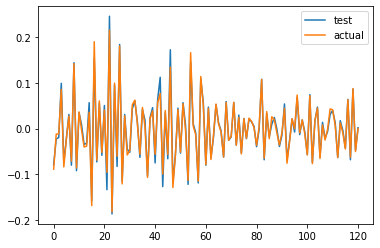

In [50]:
plt.plot(y_test, label = 'test')
plt.plot(y_pred, label = 'actual')
plt.legend()

In [51]:
((y_pred.flatten() > 0) == (y_test>0)).mean()

0.9669421487603306

In [52]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 128)         53376     
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 93,249
Trainable params: 93,249
Non-trainable params: 0
_________________________________________________________________
